In [1]:
# import sys
# import os
# import subprocess
# import yaml
# import pandas as pd
# from line_profiler import LineProfiler
import cProfile
import numpy as np
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import ipywidgets as widgets
from IPython.display import display
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
# Add the path to housing_app to the Python path, if it's not in the folder
# TODO: Adjust the path to match the local location of housing_app
# sys.path.append('/Users/k4robins/Devel/0_Thesis/housing_app')
# from housing_app.model.model import City
# Alternatively, if the housing_app is in the current folder, directly import it
from model.model import City

In [2]:
# Set parameter values and run simulation
# Do param sweep with gamma (exponential), A and price (quadratic together)
num_steps  = 20
parameters = {
            'run_notes': 'Debugging model.',
            'subfolder': None,
            'width': 15,
            'height':15,

            # FLAGS
            'demographics_on': True,  # Set flag to False for debugging to check firm behaviour without demographics or housing market
            'center_city':     False, # Flag for city center in center if True, or bottom corner if False
            # 'random_init_age': False,  # Flag for randomizing initial age. If False, all workers begin at age 0
            'random_init_age': True,  # Flag for randomizing initial age. If False, all workers begin at age 0

            # LABOUR MARKET AND FIRM PARAMETERS
            'subsistence_wage': 40000., # psi
            'init_city_extent': 10.,    # CUT OR CHANGE?
            'seed_population': 400,
            'init_wage_premium_ratio': 0.2, # 1.2, ###

            # PARAMETERS MOST LIKELY TO AFFECT SCALE
            'c': 300.0,                            ###
            'price_of_output': 10,                 ######
            'density':600,                         #####
            'A': 3000,                             ### 
            'alpha': 0.18,
            'beta':  0.75,
            'gamma': 0.12, ### reduced from .14
            'overhead': 1,
            'mult': 1.2,
            'adjN': 0.15,
            'adjk': 0.05,
            'adjn': 0.25,
            'adjF': 0.15,
            'adjw': 0.15, 
            'dist': 1, 
            'init_agglomeration_population': 100000.0,
            'init_F': 100.0,
            'init_k': 100.0,
            'init_n': 100.0,

            # HOUSING AND MORTGAGE MARKET PARAMETERS
            'mortgage_period': 5.0,       # T, in years
            'working_periods': 40,        # in years
            'savings_rate': 0.3,
            'discount_rate': 0.07,        # 1/delta
            'r_prime': 0.05,
            'r_margin': 0.01,
            'property_tax_rate': 0.04,     # tau, annual rate, was c
            'housing_services_share': 0.3, # a
            'maintenance_share': 0.2,      # b
            'max_mortgage_share': 0.9,
            'ability_to_carry_mortgage': 0.28,
            'wealth_sensitivity': 0.1,
        }

def run_simulation(num_steps, parameters):
    city = City(num_steps, **parameters)
    city.run_model()

    agent_out = city.datacollector.get_agent_vars_dataframe()
    model_out = city.datacollector.get_model_vars_dataframe()
    return agent_out, model_out


agent_out, model_out = run_simulation(num_steps, parameters)
# Turn on for timing
# cProfile.run("agent_out, model_out = run_simulation(num_steps, parameters)", sort='cumulative')

In [3]:
# Setup variables for plotting

# Filter agent data
person_df = agent_out.query("agent_type == 'Person'").dropna(axis=1, how='all').reset_index(drop=True)
land_df = agent_out.query("agent_type == 'Land'").dropna(axis=1, how='all').reset_index(drop=True)

# Get time steps
# TODO get time steps from model df? Do I just need lenth/no time_steps
time_steps = person_df['time_step'].unique()
num_time_steps = len(time_steps)
person_middle_time_step = time_steps[num_time_steps // 2]

# Define the time steps and number of time steps to plot
time_steps_to_plot = 5

# # Get unique time steps from the person_df
# time_steps = person_df['time_step'].unique()
# num_time_steps = len(time_steps)

# Calculate the time step intervals
time_step_interval = max(1, num_time_steps // (time_steps_to_plot - 1))

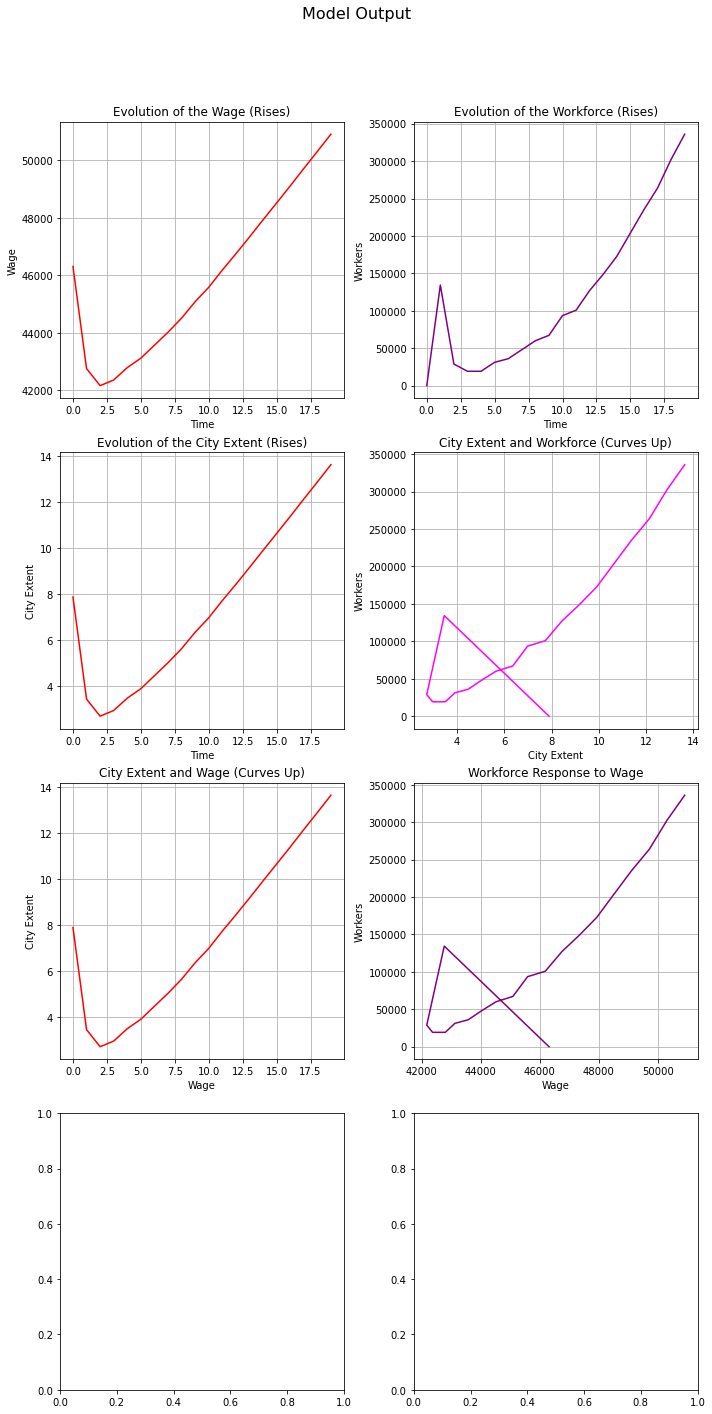

In [26]:
# Plot model output
def plot_model_data(model_out):
    workers = np.array(model_out['workers'])
    wage_premium = np.array(model_out['wage_premium'])
    wage    = np.array(model_out['wage'])
    city_extent_calc = np.array(model_out['city_extent_calc'])
    time    = np.arange(len(workers))

#     # Extract additional variables from model_out
#     n = np.array(model_out['n'])
#     y = np.array(model_out['y'])
#     MPL = np.array(model_out['MPL'])
#     MPK = np.array(model_out['MPK'])
#     n_target = np.array(model_out['n_target'])
#     y_target = np.array(model_out['y_target'])
#     k_target = np.array(model_out['k_target'])
#     adj_f = np.array(model_out['adj_f'])
#     F_target = np.array(model_out['F_target'])
#     F_next = np.array(model_out['F_next'])
#     N_target_total = np.array(model_out['N_target_total'])
#     F_next_total = np.array(model_out['F_next_total'])
#     F = np.array(model_out['F'])
#     k = np.array(model_out['k'])

    fig, axes = plt.subplots(4, 2, figsize=(10, 20))
    fig.suptitle('Model Output', fontsize=16)

    # Subplot 0L: Evolution of the Wage  
    axes[0, 0].plot(time, wage, color='red')
    axes[0, 0].set_title('Evolution of the Wage (Rises)')
    axes[0, 0].set_xlabel('Time')
    axes[0, 0].set_ylabel('Wage')
    axes[0, 0].grid(True)

    # Subplot 0R: Evolution of the Workforce
    axes[0, 1].plot(time, workers, color='purple') 
    axes[0, 1].set_title('Evolution of the Workforce (Rises)')
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_ylabel('Workers')
    axes[0, 1].grid(True)

    # Subplot 1L: Evolution of the City Extent
    axes[1,0].plot(time, city_extent_calc, color='red')
    axes[1,0].set_title('Evolution of the City Extent (Rises)')
    axes[1,0].set_xlabel('Time')
    axes[1,0].set_ylabel('City Extent')
    axes[1,0].grid(True)

    # Subplot 1R: City Extent and Workforce
    axes[1, 1].plot(city_extent_calc, workers, color='magenta')
    axes[1, 1].set_title('City Extent and Workforce (Curves Up)')
    axes[1, 1].set_xlabel('City Extent')
    axes[1, 1].set_ylabel('Workers')
    axes[1, 1].grid(True)
    
    # Subplot 2L: City Extent and Wage
    axes[2, 0].plot(time, city_extent_calc, color='red')
    axes[2, 0].set_title('City Extent and Wage (Curves Up)')
    axes[2, 0].set_xlabel('Wage')
    axes[2, 0].set_ylabel('City Extent')
    axes[2, 0].grid(True)

    # Subplot 2R: Workforce Response to Wage
    axes[2, 1].plot(wage, workers, color='purple')
    axes[2, 1].set_title('Workforce Response to Wage')
    axes[2, 1].set_xlabel('Wage')
    axes[2, 1].set_ylabel('Workers')
    axes[2, 1].grid(True)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    
plot_model_data(model_out)

/var/folders/8x/m5kmbvj1165_088_hxrpv4740000gn/T/ipykernel_14025/2675321123.py:135: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


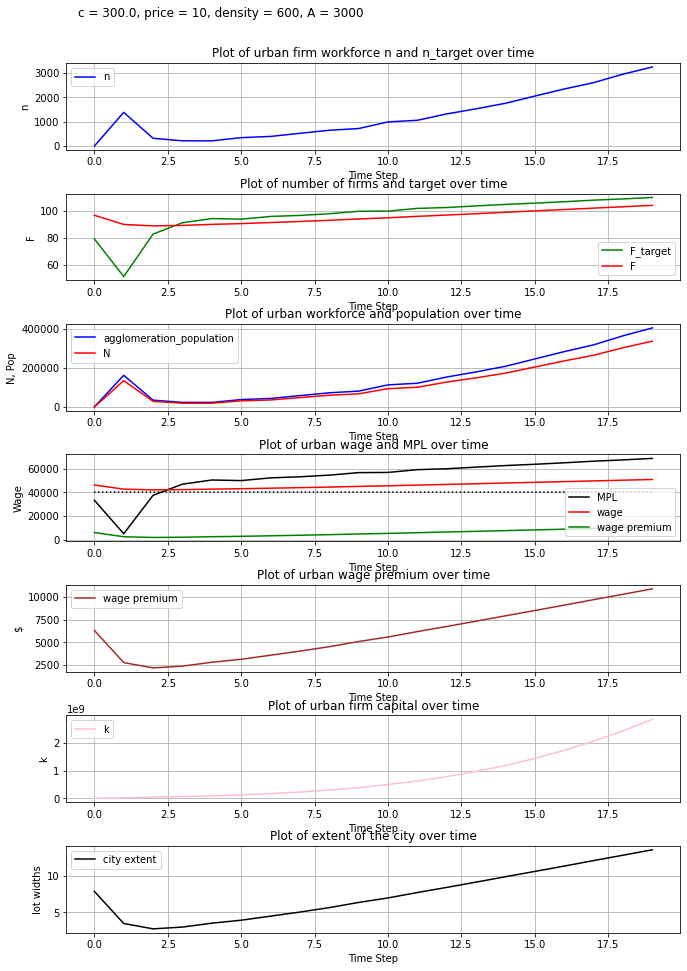

In [6]:
# Create a time array for the x-axis
time = np.arange(len(model_out['workers']))
# Create subplots with increased spacing
fig, axes = plt.subplots(7, 1, figsize=(11, 16)) # NUMBER OF PLOTS
# Adjust subplot spacing
fig.subplots_adjust(hspace=0.5)

# PRINT OUT PARAMETERS WITH PLOT
c_value = parameters['c'] #                    LIST PARAMETERS
price_of_output_value = parameters['price_of_output']
density_value = parameters['density']
A_value = parameters['A']

param_string = f'c = {c_value}, price = {price_of_output_value}, density = {density_value}, A = {A_value}'
plt.text(0.5, 0.92, param_string, transform=fig.transFigure, fontsize=12, ha='right')
 
# DESCRIBE PLOTS WANTED 
# Plot n
axes[0].plot(time, model_out['n'], label='n', color='blue')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('n')
axes[0].set_title('Plot of urban firm workforce n and n_target over time')
axes[0].grid(True)
axes[0].legend()

# axes[0].plot(time, model_out['n_target'], label='n_target', color='red')
# axes[0].set_xlabel('Time Step')
# axes[0].set_ylabel('n_target')
# #axes[0].set_title('Plot of urban firm workforce over time')
# axes[0].grid(True)
# axes[0].legend()

# Plot F ande F_target
axes[1].plot(time, model_out['F_target'], label='F_target', color='green')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('F_target')
#axes[1].set_title('Plot of target number of firms over time')
axes[1].grid(True)
axes[1].legend()

axes[1].plot(time, model_out['F'], label='F', color='red')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('F')
axes[1].set_title('Plot of number of firms and target over time')
axes[1].grid(True)
axes[1].legend()

# Plot N
axes[2].plot(time, model_out['agglomeration_population'], label='agglomeration_population', color='blue')
axes[2].plot(time, model_out['N'], label='N', color='red') 
axes[2].set_xlabel('Time Step')
axes[2].set_ylabel('N, Pop')
axes[2].set_title('Plot of urban workforce and population over time')
axes[2].grid(True)
axes[2].legend()

# # Plot Urban population
# axes[3].plot(time, model_out['agglomeration_population'], label='agglomeration_population', color='purple')
# axes[3].set_xlabel('Time Step')
# axes[3].set_ylabel('Agglomeration Population')
# axes[3].set_title('Plot of population over time')
# axes[3].grid(True)
# axes[3].legend()

# Plot w , MPL
axes[3].plot(time, model_out['MPL'], label='MPL', color='black')   
axes[3].plot(time, model_out['wage'], label='wage', color='red')
axes[3].plot(time, model_out['subsistence_wage'], ls = 'dotted', color='black')
axes[3].plot(time, model_out['wage_premium'], label='wage premium', color='green')
axes[3].set_xlabel('Time Step')
axes[3].set_ylabel('Wage')
axes[3].set_title('Plot of urban wage and MPL over time')
axes[3].grid(True)
axes[3].legend()


# # Plot y   ####   #3  HAD NO EFFECT
# # Y = parameters['price_of_output'] * model_out['A_F'] * (parameters['mult'] * model_out['N'] + parameters['seed_population']) ** parameters['gamma'] * model_out['k'] ** parameters['alpha_F'] * model_out['n'] ** parameters['beta_F']
# axes[4].plot(time, model_out['y'], label='firm output', color='orange')
# axes[4].set_xlabel('Time Step')
# axes[4].set_ylabel('')
# axes[4].set_title('Plot of firm output over time')
# axes[4].grid(True)
# axes[4].legend()

# Plot wage_premium    
axes[4].plot(time, model_out['wage_premium'], label='wage premium', color='brown')
axes[4].set_xlabel('Time Step')
axes[4].set_ylabel('$')
axes[4].set_title('Plot of urban wage premium over time')
axes[4].grid(True)
axes[4].legend()

# Plot k
axes[5].plot(time, model_out['k'], label='k', color='pink')
axes[5].set_xlabel('Time Step')
axes[5].set_ylabel('k')
axes[5].set_title('Plot of urban firm capital over time')
axes[5].grid(True)
axes[5].legend()

# Plot  dist
axes[6].plot(time, model_out['city_extent_calc'], label='city extent', color='black')
axes[6].set_xlabel('Time Step')
axes[6].set_ylabel('lot widths')
axes[6].set_title('Plot of extent of the city over time')
axes[6].grid(True)
axes[6].legend()

# # Plot  MPL
# axes[8].plot(time, model_out['MPL'], label='MPL', color='pink')
# axes[8].set_xlabel('Time Step')
# axes[8].set_ylabel('MPL')
# axes[8].set_title('Plot of MPL over time')
# axes[8].grid(True)
# axes[8].legend()

# # Plot MPL   ####  # 5 new  COMPLETELY MISSING!!
# axes[9].plot(time, model_out['MPL'], label='MPL', color='pink')
# #axes[9].plot(time, model_out['MPK'], label='MPK', color='blue')
# axes[9].set_xlabel('Time Step')
# axes[9].set_ylabel('MPL')
# axes[9].set_title('Plot of marginal product of labour over time')
# axes[9].grid(True)
# axes[9].legend()

# # Plot n_target  
# axes[10].plot(time, model_out['n_target'], label='MPL', color='red')
# axes[10].set_xlabel('Time Step')
# axes[10].set_ylabel('n_target')
# axes[10].set_title('Plot of n_target over time')
# axes[10].grid(True)
# axes[10].legend()

plt.tight_layout()

plt.show()

In [7]:
# Heatmap grid fast, plotly - 5 plots 5 data

# Define the names for each row
row_names = ['Is Working', 'Warranted Price', 'Realized Price', 'Owner']

# Create subplots with Plotly
fig = sp.make_subplots(rows=4, cols=time_steps_to_plot, shared_yaxes=True)

# Define a custom color scale for the heatmap
color_scale = [[0, 'blue'], [1, 'red']]

# Create a list to store the titles for the columns
column_titles = []

# Set a fixed height for each row
row_height = 0.2  # You can adjust the height as needed

for i in range(time_steps_to_plot):
    time_step_index = min(i * time_step_interval, num_time_steps - 1)
    time_step = time_steps[time_step_index]
    person_df_at_time_step = person_df.query("time_step == @time_step")
    land_df_at_time_step = land_df.query("time_step == @time_step")

    # Calculate the number of rows and columns for each subplot
    num_rows, num_cols = 2, 3  # You can adjust these values to your preference

    # Create y-axis titles for the first plot in each row
    y_titles = [row_names[j] if j == 0 else '' for j in range(4)]

    # Create an Is Working Heatmap with square aspect ratio and a colorbar
    heatmap1 = go.Heatmap(
        x=person_df_at_time_step['x'],
        y=person_df_at_time_step['y'],
        z=person_df_at_time_step['is_working'],
        colorscale=color_scale,
        colorbar=dict(title='Is Working'),
        showlegend=(i == 0)  # Show legend for the first plot in each row
    )
    fig.add_trace(heatmap1, row=1, col=i+1)

    # Create a Warranted Price Heatmap with square aspect ratio and a colorbar
    heatmap2 = go.Heatmap(
        x=land_df_at_time_step['x'],
        y=land_df_at_time_step['y'],
        z=land_df_at_time_step['warranted_price'],
        colorscale='Viridis',
        colorbar=dict(title='Warranted Price'),
        showlegend=(i == 0)  # Show legend for the first plot in each row
    )
    fig.add_trace(heatmap2, row=2, col=i+1)

    # Create a Realized Price Heatmap with square aspect ratio and a colorbar
    heatmap3 = go.Heatmap(
        x=land_df_at_time_step['x'],
        y=land_df_at_time_step['y'],
        z=land_df_at_time_step['realized_price'],
        colorscale='Viridis',
        colorbar=dict(title='Realized Price'),
        showlegend=(i == 0)  # Show legend for the first plot in each row
    )
    fig.add_trace(heatmap3, row=3, col=i+1)

    # Add the time step as a column title
    column_titles.append(f'Time Step {time_step}')

# Update the layout to set y-axis titles
for j, title in enumerate(row_names):
    fig.update_yaxes(title_text=title, row=j+1, col=1)

# Update the layout to set column titles
fig.update_layout(
    title_text="Visualizations with Plotly",
    width=1000,
    height=1000,  # Adjust the height as needed
    title_x=0.5,  # Center the title
    title_y=0.97,  # Adjust the title position
)

for i, title in enumerate(column_titles):
    fig.update_xaxes(title_text=title, row=4, col=i+1)

fig.show()


In [8]:
# Slider heatmap for realized price

# Compute the minimum and maximum realized_price values over all time steps
min_realized_price = land_df['realized_price'].min()
max_realized_price = land_df['realized_price'].max()

# Define a function to display the realized_price heatmap at a specific timestep
def plot_realized_price_heatmap(timestep=0):
    plt.figure(figsize=(8, 6))
    time_step = time_steps[timestep]
    land_df_at_time_step = land_df.query("time_step == @time_step")
    
    grid_size = (person_df['x'].max() + 1, person_df['y'].max() + 1)
    heatmap = np.zeros(grid_size)
    
    for index, row in land_df_at_time_step.iterrows():
        x = int(row['x'])
        y = int(row['y'])
        realized_price = row['realized_price']
        heatmap[x, y] = realized_price
    
    plt.imshow(heatmap, cmap='coolwarm', origin='lower', extent=[0, grid_size[0], 0, grid_size[1]], vmin=min_realized_price, vmax=max_realized_price)
    plt.title(f'Realized Price (Timestep: {time_step})')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(False)
    plt.colorbar()
    plt.show()

# Create a slider widget for controlling the timestep
timestep_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(time_steps) - 1,
    step=1,
    description='Timestep:'
)

# Create an interactive heatmap using the interactive function
interactive_heatmap = widgets.interactive(plot_realized_price_heatmap, timestep=timestep_slider)

# Display the interactive heatmap
display(interactive_heatmap)


interactive(children=(IntSlider(value=0, description='Timestep:', max=19), Output()), _dom_classes=('widget-in…

In [9]:
# Slider for 3 heatmaps for is_working, is_working_check, and warranted_price

 # Define a function to display heatmaps at a specific timestep
def plot_heatmaps(timestep=0):
    plt.figure(figsize=(15, 15))
    
    # Iterate over rows and plot each heatmap
    for row_index, (title, data) in enumerate(zip(row_titles, data_for_heatmaps)):
        plt.subplot(3, 1, row_index + 1)
        
        if data is not None:
            time_step = time_steps[timestep]  # Moved this line inside the 'if' block
            agents = data.query("time_step == @time_step")
        
            grid_size = (data['x'].max() + 1, data['y'].max() + 1)
            heatmap = np.zeros(grid_size)
            
            if title in ['Is Working Heatmap', 'Is Working Check']:
                value_column = 'is_working' if title == 'Is Working Heatmap' else 'is_working_check'
                
                # Fill the heatmap with the specified values
                for index, row in agents.iterrows():
                    x, y, value = int(row['x']), int(row['y']), row[value_column]
                    heatmap[x, y] = value
            elif title == 'Warranted Price Heatmap':
                # Fill the heatmap with the 'warranted_price' values
                for index, row in agents.iterrows():
                    x, y, value = int(row['x']), int(row['y']), row['warranted_price']
                    heatmap[x, y] = value

            plt.imshow(heatmap, cmap='coolwarm' if title in ('Is Working Heatmap', 'Is Working Check') else 'viridis', origin='lower', extent=[0, grid_size[0], 0, grid_size[1]], vmin=0 if title == 'Is Working Heatmap' else None)
            plt.title(f'{title} (Timestep: {time_step})')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.grid(False)
            plt.colorbar()

    plt.tight_layout()
    plt.show()

# Row titles and data for heatmaps
row_titles = ['Is Working Heatmap', 'Is Working Check', 'Warranted Price Heatmap']
data_for_heatmaps = [person_df, person_df, land_df]  # None for Scatter Plots

# Create a slider widget for controlling the timestep
timestep_slider = widgets.IntSlider(
value=0,
min=0,
max=len(time_steps) - 1,
step=1,
description='Timestep:'
)

# Create an interactive function using the widgets
interactive_heatmaps = widgets.interactive(plot_heatmaps, timestep=timestep_slider)

# Display the interactive function
display(interactive_heatmaps)

interactive(children=(IntSlider(value=0, description='Timestep:', max=19), Output()), _dom_classes=('widget-in…

In [10]:
# Slider scatter plot for realized vs warranted price

realized_price_land_df = land_df[land_df['realized_price'] != -1]
time_step = realized_price_land_df['time_step']

def plot_prices(time_step):
    # Filter data for the selected time step
    selected_data = realized_price_land_df[realized_price_land_df['time_step'] == time_step]
    
    # Extract data
    distance_from_center = selected_data['distance_from_center']
    warranted_price = selected_data['warranted_price']
    realized_price = selected_data['realized_price']
    
    # Create a plot
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

    # Plot warranted price vs. distance from center
    plt.plot(distance_from_center, warranted_price, label='Warranted Price', marker='o', linestyle='-')

    # Plot realized price vs. distance from center
    plt.plot(distance_from_center, realized_price, label='Realized Price', marker='x', linestyle='-')

    # Set labels and title
    plt.xlabel('Distance from Center')
    plt.ylabel('Price')
    plt.title('Warranted Price vs. Realized Price')

    # Add a legend
    plt.legend()

    plt.grid(True)
    plt.show()

# Create an interactive slider for selecting the time step
widgets.interact(plot_prices, time_step=widgets.IntSlider(min=time_step.min(), max=time_step.max(), step=1, value=time_step.min()));


interactive(children=(IntSlider(value=2, description='time_step', max=20, min=2), Output()), _dom_classes=('wi…

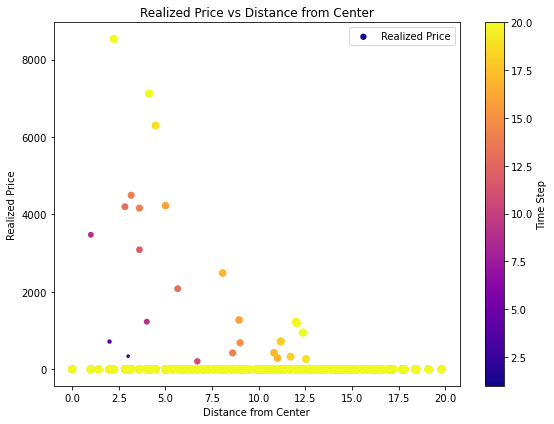

In [11]:
# Scatter shows just realized_prices not warranted price, no filters

# Extract the realized_price, distance_from_center, and time_step data
realized_prices = land_df['realized_price']
distance_from_center = land_df['distance_from_center']
time_steps = land_df['time_step']

# Define a colormap for different time steps
cmap = plt.get_cmap('plasma')

# Normalize time_steps to use as color and size
norm_time_steps = (time_steps - time_steps.min()) / (time_steps.max() - time_steps.min())
colors = cmap(norm_time_steps)
sizes = 10 + 60 * norm_time_steps

# Create a scatter plot for realized_price vs distance_from_center
plt.figure(figsize=(8, 6))
scatter = plt.scatter(distance_from_center, realized_prices, c=colors, s=sizes, marker='o', edgecolors='none', label='Realized Price')

# Set labels and title for the plot
plt.xlabel('Distance from Center')
plt.ylabel('Realized Price')
plt.title('Realized Price vs Distance from Center')

# Create a ScalarMappable to show color mapping in the legend
sm = ScalarMappable(cmap=cmap, norm=Normalize(vmin=time_steps.min(), vmax=time_steps.max()))
sm.set_array([])

# Add a colorbar legend
cbar = plt.colorbar(sm, label='Time Step', orientation='vertical')

# Show the legend
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


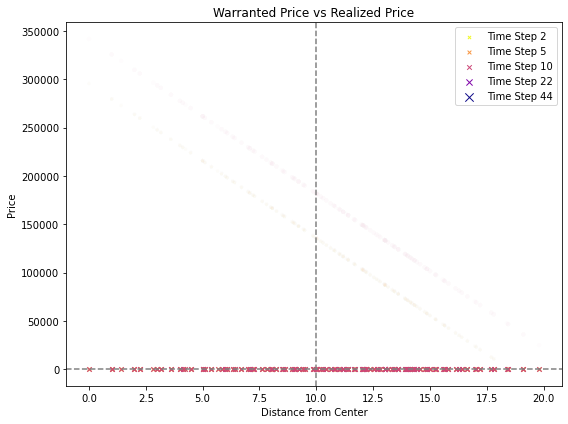

In [12]:
# Scatter plot with realized and warrented prices. Filters all but desired time steps. DOESN'T FILTER -1

# Define the time steps you want to display
selected_time_steps = [2, 5, 10, 22, 44]

# Create a scatter plot
fig, ax = plt.subplots(figsize=(8, 6))

# Define a colormap for different time steps
# cmap = cm.get_cmap('viridis', len(selected_time_steps))
cmap = cm.get_cmap('plasma', len(selected_time_steps))

# Reverse the colormap
cmap = cmap.reversed()

# Calculate min and max dot sizes
min_dot_size = 10
max_dot_size = 70

# Create dots for the selected time steps
for i, time_step in enumerate(selected_time_steps):
    land_df_at_time_step = land_df.query("time_step == @time_step") # TODO what is this?

    # Calculate dot size based on time step
    normalized_dot_size = (time_step - min(selected_time_steps)) / (max(selected_time_steps) - min(selected_time_steps))
    dot_size = min_dot_size + (max_dot_size - min_dot_size) * normalized_dot_size

    # Define the color based on the colormap
    color = cmap(i)

    # Create scatter plot for distance from center vs warranted_price with light-colored dots
    ax.scatter(land_df_at_time_step['distance_from_center'], land_df_at_time_step['warranted_price'], alpha=0.01, s=dot_size, c=color, marker='o', edgecolors='none')

    # Add darker 'x' markers for realized_price
    ax.scatter(land_df_at_time_step['distance_from_center'], land_df_at_time_step['realized_price'], label=f'Time Step {time_step}', alpha=0.99, s=dot_size, c=color, marker='x', linewidths=1)

# Set labels and title for the plot
ax.set_xlabel('Distance from Center')
ax.set_ylabel('Price')
ax.set_title('Warranted Price vs Realized Price')

# Add horizontal and vertical reference lines
ax.axhline(y=0, color='grey', linestyle='--', label='_nolegend_')  # No legend entry for the reference lines
ax.axvline(x=10, color='grey', linestyle='--', label='_nolegend_')

# Show the legend
ax.legend()

plt.tight_layout()

plt.show()


In [13]:
# # Scatter plot with realized and warrented prices. FILTERING -1 values and all but required time steps

# # Create a separate dataset with filtered realized_price
# realized_price = land_df[land_df['realized_price'] != -1]

# # Define the time steps you want to display
# selected_time_steps = [2, 5, 10, 22, 44]

# # Create a scatter plot for filtered realized_price
# fig, ax = plt.subplots(figsize=(8, 6))

# # Define a colormap for different time steps
# cmap = cm.get_cmap('plasma', len(selected_time_steps))

# # Reverse the colormap
# cmap = cmap.reversed()

# # Calculate min and max dot sizes
# min_dot_size = 10
# max_dot_size = 70

# # Create dots for the selected time steps
# for i, time_step in enumerate(selected_time_steps):
#     land_df_at_time_step = land_df.query("time_step == @time_step")

#     # Calculate dot size based on time step
#     normalized_dot_size = (time_step - min(selected_time_steps)) / (max(selected_time_steps) - min(selected_time_steps))
#     dot_size = min_dot_size + (max_dot_size - min_dot_size) * normalized_dot_size

#     # Define the color based on the colormap
#     color = cmap(i)

#     # Create scatter plot for distance from center vs warranted_price with light-colored dots
#     ax.scatter(land_df_at_time_step['distance_from_center'], land_df_at_time_step['warranted_price'], alpha=0.01, s=dot_size, c=color, marker='o', edgecolors='none')

#     # Create a separate dataset with filtered realized_price for the selected time steps
#     realized_price_time_step = realized_price.query("time_step == @time_step")

#     # Create scatter plot for filtered realized_price with darker 'x' markers
#     ax.scatter(realized_price_time_step['distance_from_center'], realized_price_time_step['realized_price'], alpha=0.99, s=dot_size, c=color, marker='x', linewidths=1, label=f'Time Step {time_step}')

# # Set labels and title for the plot
# ax.set_xlabel('Distance from Center')
# ax.set_ylabel('Price')
# ax.set_title('Warranted Price vs Filtered Realized Price')

# # Add horizontal and vertical reference lines
# ax.axhline(y=0, color='grey', linestyle='--', label='_nolegend_')  # No legend entry for the reference lines
# ax.axvline(x=10, color='grey', linestyle='--', label='_nolegend_')

# # Show the legend
# ax.legend()

# plt.tight_layout()

# plt.show()


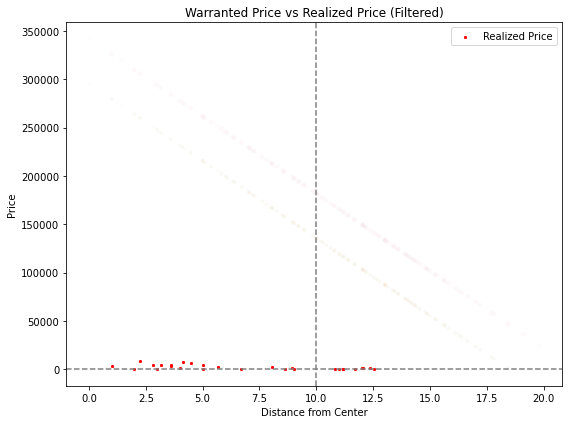

In [14]:
# Scatter plot shows all values for realized price, and a few timesteps for warranted price. FILTERS -1

# Define the time steps you want to display
selected_time_steps = [2, 5, 10, 22, 44]

# Create a scatter plot for filtered realized_price and separate dataset for every realized_price
fig, ax = plt.subplots(figsize=(8, 6))

# Define a colormap for different time steps
cmap = cm.get_cmap('plasma', len(selected_time_steps))

# Reverse the colormap
cmap = cmap.reversed()

# Calculate min and max dot sizes
min_dot_size = 10
max_dot_size = 70

# Create scatter plot for distance from center vs filtered warranted_price with light-colored dots
for i, time_step in enumerate(selected_time_steps):
    land_df_at_time_step = land_df.query("time_step == @time_step")

    # Calculate dot size based on time step
    normalized_dot_size = (time_step - min(selected_time_steps)) / (max(selected_time_steps) - min(selected_time_steps))
    dot_size = min_dot_size + (max_dot_size - min_dot_size) * normalized_dot_size

    # Define the color based on the colormap
    color = cmap(i)

    # Create scatter plot for distance from center vs warranted_price with light-colored dots
    ax.scatter(land_df_at_time_step['distance_from_center'], land_df_at_time_step['warranted_price'], alpha=0.01, s=dot_size, c=color, marker='o', edgecolors='none')

# Create a separate dataset with every realized_price value (except -1)
realized_price = land_df[land_df['realized_price'] != -1] # TODO Duplicate?

# Create scatter plot for every realized_price
ax.scatter(realized_price['distance_from_center'], realized_price['realized_price'], alpha=0.99, s=5, c='red', marker='x', label='Realized Price')

# Set labels and title for the plot
ax.set_xlabel('Distance from Center')
ax.set_ylabel('Price')
ax.set_title('Warranted Price vs Realized Price (Filtered)')

# Add horizontal and vertical reference lines
ax.axhline(y=0, color='grey', linestyle='--', label='_nolegend_')  # No legend entry for the reference lines
ax.axvline(x=10, color='grey', linestyle='--', label='_nolegend_')

# Show the legend
ax.legend()

plt.tight_layout()
plt.show()


In [15]:
# # Origional scatter? - warranted and realized price. Plot price vs distance at initilal, middle, and final time step
# # Filter agent_out data for Land agents

# # Calculate min and max dot sizes
# min_dot_size = 10
# max_dot_size = 70

# # Create a scatter plot with three dots
# fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # Create two subplots side by side

# for ax_index, ax in enumerate(axs):
#     # Create dots for the three selected time steps
#     for i, time_step in enumerate([time_steps[0], middle_time_step, time_steps[-1]]):
#         land_df_at_time_step = df.query("time_step == @time_step")

#         # Calculate dot size based on time step
#         normalized_dot_size = (time_step - min(time_steps)) / (max(time_steps) - min(time_steps))
#         dot_size = min_dot_size + (max_dot_size - min_dot_size) * normalized_dot_size

#         # Determine which variable to plot based on subplot index
#         if ax_index == 0:
#             y_variable = 'warranted_price'
#         else:
#             y_variable = 'warranted_rent'

#         # Create scatter plot for distance from center vs warranted_price or warranted_rent
#         ax.scatter(land_df_at_time_step['distance_from_center'], land_df_at_time_step[y_variable], label=f'Time Step {time_step}', alpha=0.7, s=dot_size)

#     # Set labels and title for each subplot
#     ax.set_xlabel('Distance from Center')
#     ax.set_ylabel(y_variable.replace('_', ' ').title())  # Format ylabel
#     ax.set_title(f'Distance vs {y_variable.replace("_", " ").title()} - Plot {ax_index + 1}')
#     ax.legend()

# plt.tight_layout()
                 
# # Add horizontal and vertical reference lines
# plt.axhline(y = 0, xmin = 0., color ='black')# zero 
# plt.axvline(x = 10, ymin = 0., color ='red')
# plt.text(2, 6, r'zero rent', fontsize=15)

# plt.show()

In [16]:
# # Plot all model_out variables
# def plot_all_model_out_keys(model_out):
#     time = np.arange(len(model_out['workers']))

#     # Set up the figure with subplots
#     num_keys = len(model_out.keys())
#     num_cols = 5  # Number of columns in the grid
#     num_rows = (num_keys + num_cols - 1) // num_cols  # Calculate the number of rows needed
#     fig, axes = plt.subplots(num_rows, num_cols, figsize=(21, 4 * num_rows))
#     fig.suptitle('Model Output', fontsize=16)

#     # Plot each model_out key
#     model_out_keys = list(model_out.keys())
#     for i, ax in enumerate(axes.ravel()):
#         if i < len(model_out_keys):
#             model_out_key = model_out_keys[i]
#             variable = np.array(model_out[model_out_key])
#             ax.plot(time, variable, color='blue')
#             ax.set_xlabel('Time')
#             ax.set_ylabel(model_out_key)
#             ax.grid(True)

#     plt.tight_layout()
#     plt.subplots_adjust(top=0.9)
#     plt.show()
# plot_all_model_out_keys(model_out)

In [17]:
# # WRONG DATA PLOTTED, but keep since aspect ratio is actually square - to fix above. Heatmap grid fast, plotly, square

# # Define the names for each row
# row_names = ['Is Working', 'Warranted Price', 'Scatter Plot', 'Realized Price', 'Is Working']

# # Create subplots with Plotly
# fig = sp.make_subplots(rows=5, cols=time_steps_to_plot, shared_yaxes=True)

# # Define a custom color scale for the heatmap
# color_scale = [[0, 'blue'], [1, 'red']]

# # Create a list to store the titles for the columns
# column_titles = []

# # Set a fixed height for each row
# row_height = 0.2  # You can adjust the height as needed

# for i in range(time_steps_to_plot):
#     time_step_index = min(i * time_step_interval, num_time_steps - 1)
#     time_step = time_steps[time_step_index]
#     person_df_at_time_step = person_df.query("time_step == @time_step")
#     land_df_at_time_step = land_df.query("time_step == @time_step")

#     # Calculate the number of rows and columns for each subplot
#     num_rows, num_cols = 2, 3  # You can adjust these values to your preference

#     # Create y-axis titles for the first plot in each row
#     y_titles = [row_names[j] if j == 0 else '' for j in range(5)]

#     # Create an Is Working Heatmap with square aspect ratio and a colorbar
#     heatmap1 = go.Heatmap(
#         x=person_df_at_time_step['x'],
#         y=person_df_at_time_step['y'],
#         z=person_df_at_time_step['is_working'],
#         colorscale=color_scale,
#         colorbar=dict(title='Is Working'),
#         showlegend=(i == 0)  # Show legend for the first plot in each row
#     )
#     fig.add_trace(heatmap1, row=1, col=i+1)

#     # Create a Warranted Price Heatmap with square aspect ratio and a colorbar
#     heatmap2 = go.Heatmap(
#         x=land_df_at_time_step['x'],
#         y=land_df_at_time_step['y'],
#         z=land_df_at_time_step['warranted_price'],
#         colorscale='Viridis',
#         colorbar=dict(title='Warranted Price'),
#         showlegend=(i == 0)  # Show legend for the first plot in each row
#     )
#     fig.add_trace(heatmap2, row=2, col=i+1)

#     # Create a Scatter Plot
#     scatter = px.scatter(land_df_at_time_step, x='distance_from_center', y='warranted_price',
#                          title=f'Scatter Plot (Time Step {time_step})')
#     fig.add_trace(scatter['data'][0], row=3, col=i+1)

#     # Create a Realized Price Heatmap with square aspect ratio and a colorbar
#     heatmap3 = go.Heatmap(
#         x=land_df_at_time_step['x'],
#         y=land_df_at_time_step['y'],
#         z=land_df_at_time_step['realized_price'],
#         colorscale='Viridis',
#         colorbar=dict(title='Realized Price'),
#         showlegend=(i == 0)  # Show legend for the first plot in each row
#     )
#     fig.add_trace(heatmap3, row=4, col=i+1)

#     # Create a second Is Working Heatmap (Version 2) with square aspect ratio and a colorbar
#     heatmap4 = go.Heatmap(
#         x=person_df_at_time_step['x'],
#         y=person_df_at_time_step['y'],
#         z=person_df_at_time_step['is_working'],
#         colorscale=color_scale,
#         colorbar=dict(title='Is Working'),
#         showlegend=(i == 0)  # Show legend for the first plot in each row
#     )
#     fig.add_trace(heatmap4, row=5, col=i+1)

#     # Add the time step as a column title
#     column_titles.append(f'Time Step {time_step}')

# # Update the layout to set y-axis titles
# for j, title in enumerate(row_names):
#     fig.update_yaxes(title_text=title, row=j+1, col=1)

# # Update the layout to set column titles
# fig.update_layout(
#     title_text="Visualizations with Plotly",
#     width=1000,
#     height=1000,  # Adjust the height as needed
#     title_x=0.5,  # Center the title
#     title_y=0.97,  # Adjust the title position
# )

# for i, title in enumerate(column_titles):
#     fig.update_xaxes(title_text=title, row=5, col=i+1)

# fig.show()


In [18]:
# # Matplotlib three heatmaps

# # Create subplots with 3 rows and 3 columns
# fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# # Iterate over the subplots and time steps for Person data
# for i, time_step in enumerate([time_steps[0], person_middle_time_step, time_steps[-1]]):
#     person_df_at_time_step = person_df.query("time_step == @time_step")
    
#     # Create a grid to represent the space
#     grid_size = (person_df['x'].max() + 1, person_df['y'].max() + 1)
#     heatmap = np.zeros(grid_size)
    
#     # Fill the heatmap with the 'is_working' values
#     for index, row in person_df_at_time_step.iterrows():
#         x = int(row['x'])
#         y = int(row['y'])
#         is_working = row['is_working']
#         heatmap[x, y] = is_working
    
#     # Display the heatmap in the current subplot
#     im = axs[0, i].imshow(heatmap, cmap='coolwarm', origin='lower', extent=[0, grid_size[0], 0, grid_size[1]], vmin=0, vmax=1)
#     axs[0, i].set_title(f'Person Time Step {time_step}')
#     axs[0, i].set_xlabel('X')
#     axs[0, i].set_ylabel('Y')
#     axs[0, i].grid(False)

# # Iterate over the subplots and time steps for Land data
# for i, time_step in enumerate([time_steps[0], person_middle_time_step, time_steps[-1]]):
#     land_df_at_time_step = land_df.query("time_step == @time_step")
    
#     # Create a grid to represent the space
#     grid_size = (land_df['x'].max() + 1, land_df['y'].max() + 1)
#     heatmap = np.zeros(grid_size)
    
#     # Fill the heatmap with the values
#     for index, row in land_df_at_time_step.iterrows():
#         x = int(row['x'])
#         y = int(row['y'])
#         price = row['warranted_price']
#         heatmap[x, y] = price
    
#     # Display the heatmap in the current subplot
#     im = axs[1, i].imshow(heatmap, cmap='viridis', origin='lower', extent=[0, grid_size[0], 0, grid_size[1]]) #, vmin=min_price, vmax=max_price)
#     axs[1, i].grid(False)
    
#     # Create scatter plot for distance from center vs warranted price
#     scatter = axs[2, i].scatter(land_df_at_time_step['distance_from_center'], land_df_at_time_step['warranted_price'], c='blue', alpha=0.5)
#     axs[2, i].set_title(f'Distance vs Warranted Price at Time Step {time_step}')
#     axs[2, i].set_xlabel('Distance from Center')
#     axs[2, i].set_ylabel('Warranted Price')
#     axs[2, i].grid(True)
    
#     # Set same min and max values for scatter plots
#     # axs[2, i].set_ylim(min_price, max_price)

# # Add a common colorbar
# divider = make_axes_locatable(axs[1, 2])
# cax = divider.append_axes("right", size="5%", pad=0.1)
# cbar = plt.colorbar(im, cax=cax, ticks=[0, 1])
# cbar.set_label('Is Working')

# plt.tight_layout()
# plt.show()

In [19]:
# # Matplotlib 5 heatmaps - slower 5.6s was MAIN has another line for realized price - works

# # Create subplots with 4 rows and time_steps_to_plot columns
# fig, axs = plt.subplots(4, time_steps_to_plot, figsize=(15, 15))

# # Row titles
# row_titles = ['Is Working Heatmap', 'Warranted Price Heatmap', 'Scatter Plots', 'Realized Price Heatmap']

# # Iterate over rows and columns
# for row_index in range(4):
#     for col_index in range(time_steps_to_plot):
#         if col_index == 0:
#             axs[row_index, col_index].set_title(row_titles[row_index])  # Set row title for the first subplot in each row
#         else:
#             axs[row_index, col_index].set_title("")  # Set an empty title for other subplots in the same row

# # Iterate over the subplots and evenly spaced time steps for Person data
# for i in range(time_steps_to_plot):
#     time_step_index = min(i * time_step_interval, num_time_steps - 1)
#     time_step = time_steps[time_step_index] # TODO fix redundancy
#     person_df_at_time_step = person_df.query("time_step == @time_step")
    
#     # Create a grid to represent the space
#     grid_size = (person_df['x'].max() + 1, person_df['y'].max() + 1)
#     heatmap = np.zeros(grid_size)
    
#     # Fill the heatmap with the 'is_working' values
#     for index, row in person_df_at_time_step.iterrows():
#         x = int(row['x'])
#         y = int(row['y'])
#         is_working = row['is_working']
#         heatmap[x, y] = is_working
    
#     # Display the 'is_working' heatmap in the current subplot
#     row_index = 0
#     col_index = i
#     im = axs[row_index, col_index].imshow(heatmap, cmap='coolwarm', origin='lower', extent=[0, grid_size[0], 0, grid_size[1]], vmin=0, vmax=1)
#     axs[row_index, col_index].set_xlabel('X')
#     axs[row_index, col_index].set_ylabel('Y')
#     axs[row_index, col_index].grid(False)

# # Iterate over the subplots and evenly spaced time steps for Land data
# for i in range(time_steps_to_plot):
#     time_step_index = min(i * time_step_interval, num_time_steps - 1)
#     time_step = time_steps[time_step_index]
#     land_df_at_time_step = land_df.query("time_step == @time_step")
    
#     # Create a grid to represent the space
#     grid_size = (land_df['x'].max() + 1, land_df['y'].max() + 1)
#     heatmap = np.zeros(grid_size)
    
#     # Fill the heatmap with the 'warranted_price' values
#     for index, row in land_df_at_time_step.iterrows():
#         x = int(row['x'])
#         y = int(row['y'])
#         price = row['warranted_price']
#         heatmap[x, y] = price
    
#     # Display the 'warranted_price' heatmap in the current subplot
#     row_index = 1
#     col_index = i
#     im = axs[row_index, col_index].imshow(heatmap, cmap='viridis', origin='lower', extent=[0, grid_size[0], 0, grid_size[1]])
#     axs[row_index, col_index].grid(False)

# # Create a row of 5 scatter plots
# for i in range(time_steps_to_plot):
#     time_step_index = min(i * time_step_interval, num_time_steps - 1)
#     time_step = time_steps[time_step_index]
#     land_df_at_time_step = land_df.query("time_step == @time_step")
    
#     row_index = 2
#     col_index = i
    
#     # Create scatter plot for distance from center vs warranted price
#     scatter = axs[row_index, col_index].scatter(land_df_at_time_step['distance_from_center'], land_df_at_time_step['warranted_price'], c='blue', alpha=0.5)
#     axs[row_index, col_index].set_xlabel('Distance from Center')
#     axs[row_index, col_index].set_ylabel('Warranted Price')
#     axs[row_index, col_index].grid(True)

# # Iterate over the subplots and evenly spaced time steps for Land data
# for i in range(time_steps_to_plot):
#     time_step_index = min(i * time_step_interval, num_time_steps - 1)
#     time_step = time_steps[time_step_index]
#     land_df_at_time_step = land_df.query("time_step == @time_step")
    
#     # Create a grid to represent the space
#     grid_size = (land_df['x'].max() + 1, land_df['y'].max() + 1)
#     heatmap = np.zeros(grid_size)
    
#     # Fill the heatmap with the 'realized_price' values
#     for index, row in land_df_at_time_step.iterrows():
#         x = int(row['x'])
#         y = int(row['y'])
#         price = row['realized_price']
#         heatmap[x, y] = price
    
#     # Display the 'realized_price' heatmap in the current subplot
#     row_index = 3
#     col_index = i
#     im = axs[row_index, col_index].imshow(heatmap, cmap='viridis', origin='lower', extent=[0, grid_size[0], 0, grid_size[1]])
#     axs[row_index, col_index].grid(False)

# # Add a common colorbar
# divider = make_axes_locatable(axs[1, time_steps_to_plot - 1])
# cax = divider.append_axes("right", size="5%", pad=0.1)
# cbar = plt.colorbar(im, cax=cax, ticks=[0, 1])
# cbar.set_label('Is Working / Warranted Price / Realized Price')

# plt.tight_layout()
# plt.show()


In [20]:
# # Small rectangle heatmap grid fast, plotly

# # Create subplots with Plotly
# fig = sp.make_subplots(rows=5, cols=time_steps_to_plot, subplot_titles=[
#     'Is Working Heatmap', 'Warranted Price Heatmap', 'Scatter Plots',
#     'Realized Price Heatmap', 'Is Working Heatmap (Version 2)'
# ])

# # Define a custom color scale for the heatmap
# color_scale = [[0, 'blue'], [1, 'red']]

# for i in range(time_steps_to_plot):
#     time_step_index = min(i * time_step_interval, num_time_steps - 1)
#     time_step = time_steps[time_step_index]
#     person_df_at_time_step = person_df.query("time_step == @time_step")
#     land_df_at_time_step = land_df.query("time_step == @time_step")

#     # Create an Is Working Heatmap
#     fig.add_trace(go.Heatmap(
#         z=person_df_at_time_step.pivot('x', 'y', 'is_working').values,
#         colorscale=color_scale,
#         colorbar=dict(title='Is Working'),
#     ), row=1, col=i+1)

#     # Create a Warranted Price Heatmap
#     fig.add_trace(go.Heatmap(
#         z=land_df_at_time_step.pivot('x', 'y', 'warranted_price').values,
#         colorscale='Viridis',
#         colorbar=dict(title='Warranted Price'),
#     ), row=2, col=i+1)

#     # Create a Scatter Plot
#     scatter = px.scatter(land_df_at_time_step, x='distance_from_center', y='warranted_price',
#                          title=f'Scatter Plot (Time Step {time_step})')
#     fig.add_trace(scatter['data'][0], row=3, col=i+1)

#     # Create a Realized Price Heatmap
#     fig.add_trace(go.Heatmap(
#         z=land_df_at_time_step.pivot('x', 'y', 'realized_price').values,
#         colorscale='Viridis',
#         colorbar=dict(title='Realized Price'),
#     ), row=4, col=i+1)

#     # Create a second Is Working Heatmap (Version 2)
#     fig.add_trace(go.Heatmap(
#         z=person_df_at_time_step.pivot('x', 'y', 'is_working').values,
#         colorscale=color_scale,
#         colorbar=dict(title='Is Working'),
#     ), row=5, col=i+1)

# fig.update_layout(title_text="Visualizations with Plotly")
# fig.show()


In [21]:
# # Fixed labels - Heatmap grid fast, plotly, square

# # Define the names for each row
# row_names = ['Is Working', 'Warranted Price', 'Scatter Plot', 'Realized Price', 'Is Working']

# # Create subplots with Plotly and set square aspect ratio
# fig = sp.make_subplots(rows=5, cols=time_steps_to_plot, shared_yaxes=True, row_heights=row_heights)

# # Define a custom color scale for the heatmap
# color_scale = [[0, 'blue'], [1, 'red']]

# # Create a list to store the titles for the columns
# column_titles = []

# for i in range(time_steps_to_plot):
#     time_step_index = min(i * time_step_interval, num_time_steps - 1)
#     time_step = time_steps[time_step_index]
#     person_df_at_time_step = person_df.query("time_step == @time_step")
#     land_df_at_time_step = land_df.query("time_step == @time_step")

#     # Calculate the number of rows and columns for each subplot
#     num_rows, num_cols = 2, 3  # You can adjust these values to your preference

#     # Create y-axis titles for the first plot in each row
#     y_titles = [row_names[j] if j == 0 else '' for j in range(5)]

#     # Create an Is Working Heatmap with square aspect ratio
#     heatmap1 = go.Heatmap(
#         x=person_df_at_time_step['x'],
#         y=person_df_at_time_step['y'],
#         z=person_df_at_time_step['is_working'],
#         colorscale=color_scale,
#         colorbar=dict(title='Is Working')
#     )
#     fig.add_trace(heatmap1, row=1, col=i+1)

#     # Create a Warranted Price Heatmap with square aspect ratio
#     heatmap2 = go.Heatmap(
#         x=land_df_at_time_step['x'],
#         y=land_df_at_time_step['y'],
#         z=land_df_at_time_step['warranted_price'],
#         colorscale='Viridis',
#         colorbar=dict(title='Warranted Price')
#     )
#     fig.add_trace(heatmap2, row=2, col=i+1)

#     # Create a Scatter Plot
#     scatter = px.scatter(land_df_at_time_step, x='distance_from_center', y='warranted_price',
#                          title=f'Scatter Plot (Time Step {time_step})')
#     fig.add_trace(scatter['data'][0], row=3, col=i+1)

#     # Create a Realized Price Heatmap with square aspect ratio
#     heatmap3 = go.Heatmap(
#         x=land_df_at_time_step['x'],
#         y=land_df_at_time_step['y'],
#         z=land_df_at_time_step['realized_price'],
#         colorscale='Viridis',
#         colorbar=dict(title='Realized Price')
#     )
#     fig.add_trace(heatmap3, row=4, col=i+1)

#     # Create a second Is Working Heatmap (Version 2) with square aspect ratio
#     heatmap4 = go.Heatmap(
#         x=person_df_at_time_step['x'],
#         y=person_df_at_time_step['y'],
#         z=person_df_at_time_step['is_working'],
#         colorscale=color_scale,
#         colorbar=dict(title='Is Working')
#     )
#     fig.add_trace(heatmap4, row=5, col=i+1)

#     # Add the time step as a column title
#     column_titles.append(f'Time Step {time_step}')

# # Update the layout to set y-axis titles
# for j, title in enumerate(row_names):
#     fig.update_yaxes(title_text=title, row=j+1, col=1)

# # Update the layout to set column titles
# fig.update_layout(
#     title_text="Visualizations with Plotly",
#     width=1000,
#     height=1000,  # Adjust the height as needed
#     title_x=0.5,  # Center the title
#     title_y=0.97,  # Adjust the title position
# )

# for i, title in enumerate(column_titles):
#     fig.update_xaxes(title_text=title, row=5, col=i+1)

# fig.show()


In [22]:
# # Slider for 1 heatmap for is_working

# # Define a function to display the is_working heatmap at a specific timestep
# def plot_is_working_heatmap(timestep=0):
#     plt.figure(figsize=(8, 6))
#     time_step = time_steps[timestep]
#     person_df_at_time_step = person_df.query("time_step == @time_step")
    
#     grid_size = (person_df['x'].max() + 1, person_df['y'].max() + 1)
#     heatmap = np.zeros(grid_size)
    
#     for index, row in person_df_at_time_step.iterrows():
#         x = int(row['x'])
#         y = int(row['y'])
#         is_working = row['is_working']
#         heatmap[x, y] = is_working
    
#     plt.imshow(heatmap, cmap='coolwarm', origin='lower', extent=[0, grid_size[0], 0, grid_size[1]], vmin=0, vmax=1)
#     plt.title(f'Is Working Heatmap (Timestep: {time_step})')
#     plt.xlabel('X')
#     plt.ylabel('Y')
#     plt.grid(False)
#     plt.colorbar()
#     plt.show()

# # Create a slider widget for controlling the timestep
# timestep_slider = widgets.IntSlider(
#     value=0,
#     min=0,
#     max=len(time_steps) - 1,
#     step=1,
#     description='Timestep:'
# )

# # Create an interactive heatmap using the interactive function
# interactive_heatmap = widgets.interactive(plot_is_working_heatmap, timestep=timestep_slider)

# # Display the interactive heatmap
# display(interactive_heatmap)


In [23]:
# # Owner type heatmap TODO Doesn't work since owner type is now a number
# # print(land_df['ownership_type'])

# # Filter to show values for a single time step (change 'time_step' to your desired time step)
# time_step = 5
# land_df_at_time_step = land_df.query("time_step == @time_step")

# # Create a dictionary to map owner types to numeric values
# ownership_type_mapping = {'Person': 0, 'Investor': 1, 'Bank': 2, 'Other': 3}
# ownership_type_labels = {0: 'Person', 1: 'Investor', 2: 'Bank', 3: 'Other'}

# # Map the owner types to numeric values in the DataFrame
# land_df_at_time_step['ownership_type_numeric'] = land_df_at_time_step['ownership_type'].map(ownership_type_mapping)

# # Create the heatmap
# plt.figure(figsize=(10, 6))
# ax = sns.heatmap(data=land_df_at_time_step.pivot_table(index='y', columns='x', values='ownership_type_numeric', fill_value=0),
#                  cmap='YlGnBu', annot=True, fmt='d', cbar_kws={'label': 'Owner Type'})

# # Set the labels for the colorbar
# cbar = ax.collections[0].colorbar
# cbar.set_ticks(list(ownership_type_labels.keys()))
# cbar.set_ticklabels(list(ownership_type_labels.values()))

# plt.title("Owner Type vs. X, Y Space at Time Step {}".format(time_step))
# plt.xlabel("X")
# plt.ylabel("Y")
# plt.show()


In [24]:
# # Plot owner type  TODO Doesn't work since owner type is now a number
# # Load your data (replace 'your_data.csv' with your dataset)
# data = land_df

# # Create an animation using Plotly Express
# fig = px.scatter(data, x='x', y='y', color='ownership_type', animation_frame='time_step',
#                  range_x=[0, max(data['x'])], range_y=[0, max(data['y'])],
#                  color_discrete_map={'Person': 'blue', 'Investor': 'red', 'Other': 'green'},
#                  title='Owner Type Over Time')

# # Customize the layout (optional)
# fig.update_layout(autosize=False, width=800, height=600)

# # Show the animation
# fig.show()